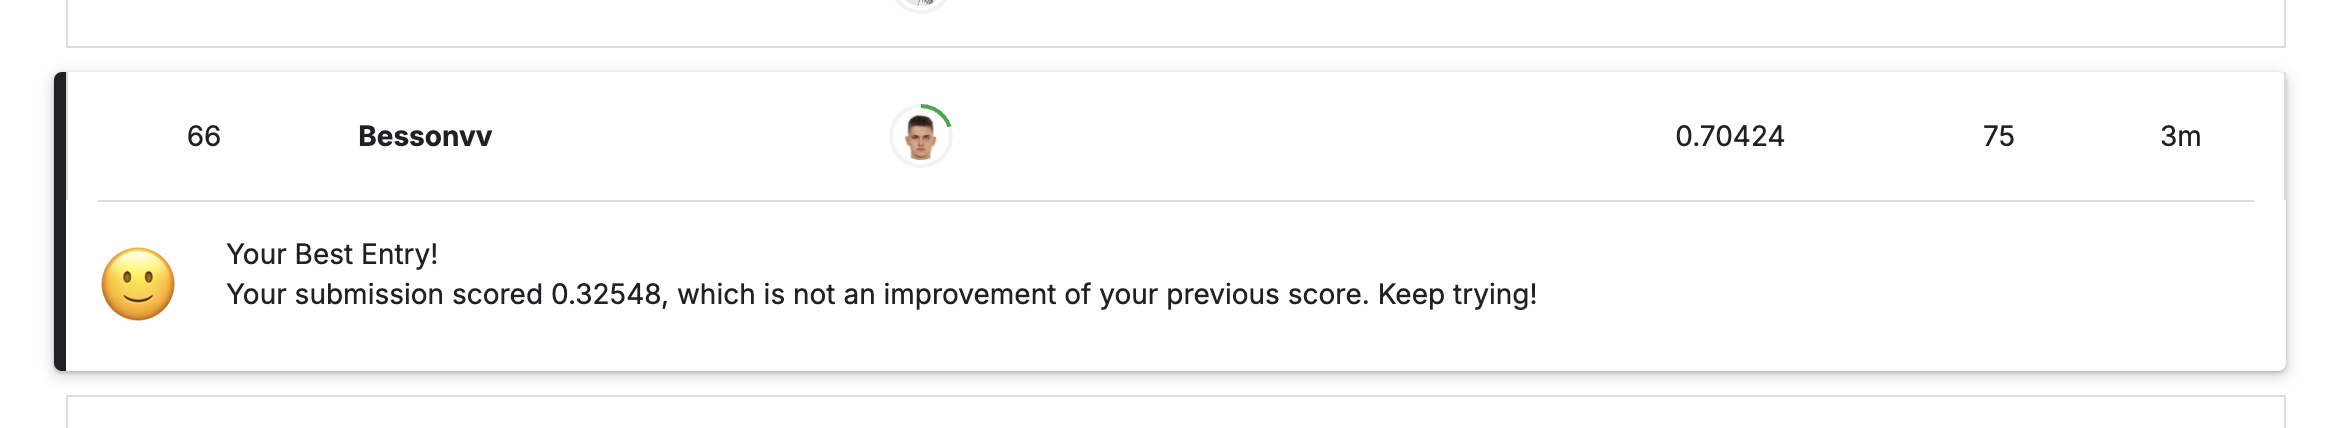

In [1515]:
from IPython.display import display, Image
display(Image('/Users/bessonv/Skillfactory/Анализ данных в Pandas/II SEM/classic ML/Сессионное задание/data/Снимок экрана 2025-06-16 в 22.10.13.png'))

# Scintillation Detector

Необходимо определить типы сигналов сцинтилляционного детектора

# Dataset Description

Вам даны данные о 23 479 сигналах с различных набором характеристик этих сигналов. Ваша задача кластеризовать эти сигналы на три кластера по типу сигналов: два кластера отображают типы сигналов (гамма-кванты или нейтроны), третий кластер представляет себя группу сигналов, которые не поддаются кластеризации. (Нумерация кластеров с 0: 0,1,2).

Files
Run200_Wave_0_1.txt - набор данных о сигналах
test-dataset.ipynb - файл-пример чтения и отображения данных

# **1 ИМПОРТ БИБЛИОТЕК**

In [1516]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns

# **2 ИССЛЕДОВАНИЕ ДАННЫХ**

## **2.1 Импорт данных**

In [1517]:
# Загрузка данных
data = pd.read_csv('/Users/bessonv/Skillfactory/Анализ данных в Pandas/II SEM/classic ML/Сессионное задание/data/Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)

data.drop(columns=[0, 1, 2, 3, 504], inplace=True)

data.columns = list(range(500))

# Выводим первые 5 строк
display(data.head())

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,...,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,...,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,...,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,...,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,...,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825


# Анализ данных

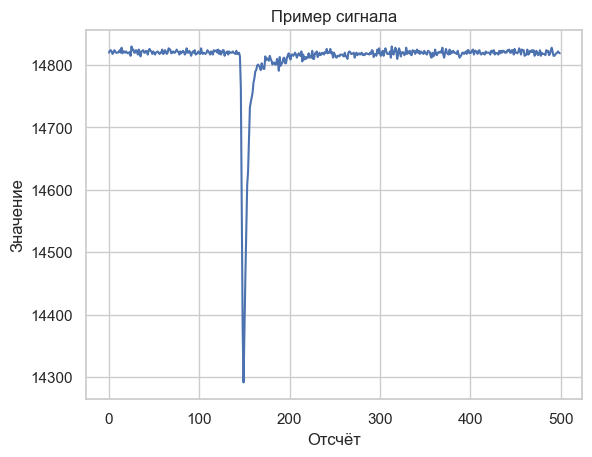

In [1518]:
example_signal = data.iloc[0, :]  # первый сигнал
plt.plot(example_signal)
plt.title("Пример сигнала")
plt.xlabel("Отсчёт")
plt.ylabel("Значение")
plt.show()

Судя по графику сигнала, он инвертирован. Так как по условию задачи мы должны наблюдать всплеск энергии, а перед нами явный спад. Попробуем инвертировать сигнал для последюущего корректного анализа и создания новых параметров.

# Инверсия сигнала

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,4,1,0,2,6,4,0,2,4,4,...,-4,2,9,9,7,5,4,2,4,5
1,4,2,4,-2,0,2,4,2,1,3,...,-4,7,0,2,0,5,4,5,2,4
2,4,4,2,-1,4,0,0,5,1,0,...,4,3,4,4,6,3,1,4,4,3
3,-4,2,6,0,0,2,4,2,0,4,...,0,-2,2,3,4,-4,4,2,1,2
4,1,9,1,3,-3,4,1,0,8,3,...,4,4,1,-4,0,4,0,0,2,-1


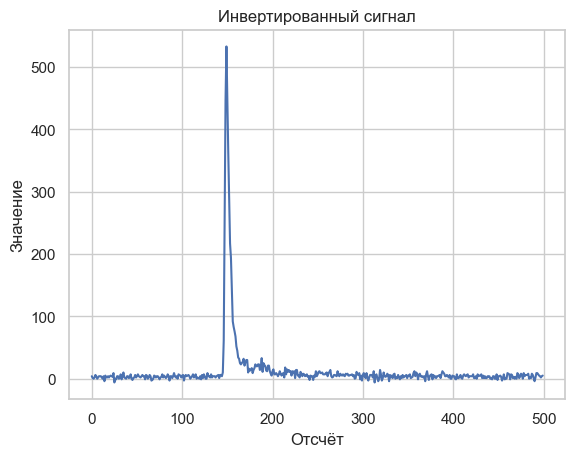

In [1519]:
# Инверсия сигнала
data=2**14-data-1560
display(data.head())

# Инвертированный сигнал
invert_signal = data.iloc[0, :] 
# График инвертированного сигнала
plt.plot(invert_signal)
plt.title("Инвертированный сигнал")
plt.xlabel("Отсчёт")
plt.ylabel("Значение")
plt.show()

Посмотрим на срез сигналов

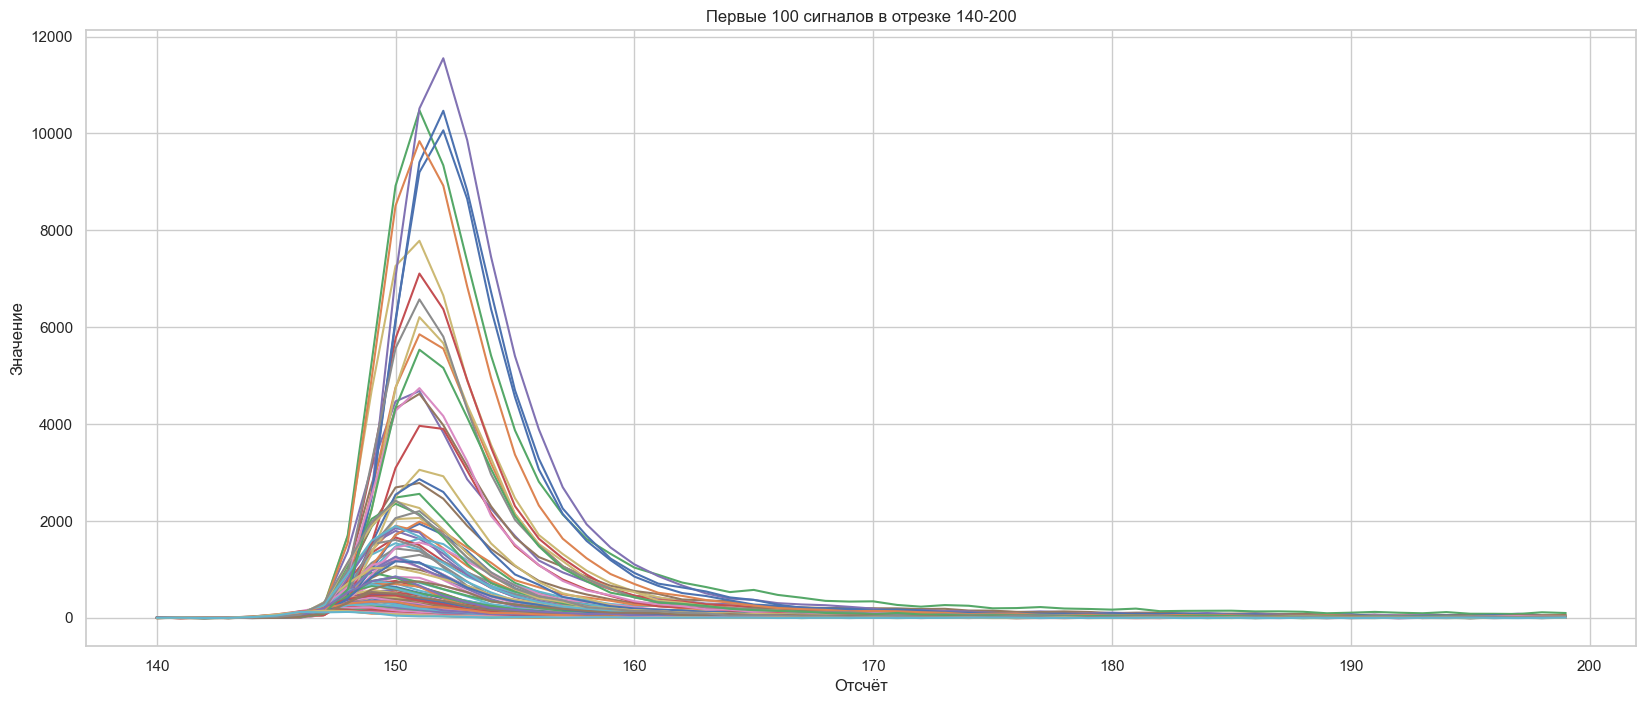

In [1520]:
# Первые 100 сигналов в отрезке 140-200
signals = data.iloc[0:100,140:200].T
signals.plot(figsize=(20, 8), legend=False)
plt.title("Первые 100 сигналов в отрезке 140-200")
plt.xlabel("Отсчёт")
plt.ylabel("Значение")
plt.show()

Если посмотреть внимательно на затухание сигналов, то можно заметить, что оно предельно разное. Мы знаем у нейтронов сильнее вспышка, чем у гамма-протонов, следственно и затухание у них дольше.

Построим модель кластеризации, которая будет опираться на форму сигнала.

В качестве параметра для кластеризации выберем кумулятивную сумму после пика сигнала. 

К 3 группе будем относить сигналы, амплитуда которых меньше 5000

# **3 FEATURE ENGINEERIING**

## **3.1 Предобработка данных**

In [1521]:
# Вычтем шум из всего датасета, чтобы корректно создавать параметры
data=data-np.reshape(data.loc[:,:100].median(axis=1).values,(-1,1))

# Заменяем все значения меньше 1 на 1
data=data.clip(lower=1)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,5.0,5.0,3.0,1.0,1.0,1.0,1.0,1.0
1,3.0,1.0,3.0,1.0,1.0,1.0,3.0,1.0,1.0,2.0,...,1.0,6.0,1.0,1.0,1.0,4.0,3.0,4.0,1.0,3.0
2,2.0,2.0,1.0,1.0,2.0,1.0,1.0,3.0,1.0,1.0,...,2.0,1.0,2.0,2.0,4.0,1.0,1.0,2.0,2.0,1.0
3,1.0,1.0,5.0,1.0,1.0,1.0,3.0,1.0,1.0,3.0,...,1.0,1.0,1.0,2.0,3.0,1.0,3.0,1.0,1.0,1.0
4,1.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## **3.2 Создание новых парметров**

In [1522]:
# Амплитуда
data['amp'] = data.max(axis=1)

# **4 КЛАСТЕРИЗАЦИЯ**

## **6.1 K-means**

Алгоритм будет следующий: Для начала 

In [1523]:
# Создание датасета в который мы будем добавлять классы [0,1,2] после кластеризации
cluster = pd.DataFrame({'cluster':[2 for i in range(len(data))]})
one = pd.DataFrame({'cumsum':[1 for i in range(len(data))]})

def clustering(begin, end, step):
    
    for i in range(begin, end, -step):
        # Создаем датасет со 500 значениями сигнала, где амплитуда в пределах i + step <= amplitude < i
        d=data.loc[(data["amp"]>i)&(data["amp"]<=(i+step)),data.columns[:-1]]
        # Ограничиваем этот датасет до столбцов 145-250
        d=d.loc[:,145:250]
        
        # Создаем список, где будут будущие значения для кластеризации
        features=[]
        # Создаем итератор по индексам нового датафрейма
        for id in d.index:
            # В текущей строке ищем столбец который хранит самое большое значение в строчке, index[-1] отвечает за то, 
            # что если максимальных значений несколько, то мы возьмем последнее. Col = Имя столбца
            col=d.loc[id,d.loc[id]==d.loc[id].max()].index[-1]
            # Берет строчку и ее столбца от ее пика + 8 значений и до пик + 60, по этим столбцам делаем кумулятивную сумму. Возвращает одномерный массив.
            vals=d.loc[id,range(col+8,col+60)].cumsum()
            # Из списка берем 30 значение и добавляем в список по которму будем предсказывать значения. 
            # Берется 30, но может быть и другое. Предполагается, что это стабилиьное значение для разделения.
            features.append(vals.iloc[29])
            one.loc[id, 'cumsum'] = vals.iloc[29]


        # Логарифмируем значения для стаблильной работы Kmeans
        features = np.log(features)
        # Создаем классификацию для двух классов, нейтроны и гамма-кванты
        estimator=KMeans(n_clusters=2)
        # Создаем объект типа Kmean, предварительно передаем ему транспонированный список, так как этого требует Kmeans
        estimator.fit(features.reshape(-1,1))

        # Сравниваем первые значения из кластеров 0 и 1, если первое значения из кластера 0 больше, то label = 0, иначе label = 1
        # 0 это нейтроны, 1 это гамма-кванты, так как у нейтронов вспышка должна быть сильнее
        label=0 if features[estimator.labels_==0][0]>features[estimator.labels_==1][0] else 1

        # Присваиваем номера кластеров
        cluster.loc[d.index[estimator.labels_==0], "cluster"]=label 
        cluster.loc[d.index[estimator.labels_==1], "cluster"]=1-label

clustering(13000,1000,1000)

# **6.2 DBSCAN**

In [1527]:
dbscan = DBSCAN()
labels = dbscan.fit_predict(one[['cumsum']])

### **6.1.1 Оценка качества**

In [1529]:
print('Kmeans')
silhouette_avg = silhouette_score(one[['cumsum']], cluster['cluster'])
print("Silhouette Score:", silhouette_avg)

print('DBSCAN')
silhouette_avg = silhouette_score(one[['cumsum']], labels)
print("Silhouette Score:", silhouette_avg)

Kmeans
Silhouette Score: 0.7347695492901731
DBSCAN
Silhouette Score: 0.5213475344471928


Алгоритм kmean показывает себя лучше

## **6.2 DBSCAN**

## **6.3 Иерархическая кластеризация**

# Экспорт данных

In [ ]:
# Сохраняем в submission.csv
submission = pd.DataFrame({
    'Index': range(len(cluster)),
    'cluster': cluster['cluster'].values
})

submission.to_csv('submission.csv', index=False)

In [ ]:
sub = pd.read_csv('/Users/bessonv/Skillfactory/Анализ данных в Pandas/II SEM/classic ML/Сессионное задание/submission.csv')
sub['cluster'].unique()

array([1, 0])